# Homework 10: Neural Networks
by Junyu Liu

**Due date**: December 12, Monday at 11:59pm


## **Question 1:** Useful Functions and Setup


In [17]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Loading Dataset (15 pts)

Using the datasets module within torchvision, download the CIFAR-10 dataset.
1. Download both the training dataset as well as the testing dataset.
2. Normalize the dataset so each channel (color) has mean of 0 and std of 1. (8 pts)

We are going to use TensorDatasets since all of the data can fit into memory. When the dataset contains many small files, which is the case here, using TensorDatasets saves us a lot of I/O operations which often take up the majority of training time.

In [18]:
# Training and validation data
train_dataset = datasets.CIFAR10('./data', train=True, download=True)
# Testing data
test_dataset = datasets.CIFAR10('./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
Xtrain = torch.FloatTensor(train_dataset.data)
Xtest = torch.FloatTensor(test_dataset.data)
Xtrain = Xtrain.moveaxis(-1, 1)
Xtest = Xtest.moveaxis(-1, 1)
ytrain = torch.LongTensor(train_dataset.targets)
ytest = torch.LongTensor(test_dataset.targets)

# Not required, but should help with numerical stability
Xtrain /= 256
Xtest /= 256

print(Xtrain.shape)

# Normalize both Xtrain and Xtest, but ONLY use mean and std of Xtrain
print(f"\n Xtrain std, mean BEFORE normalizing:")
print(torch.std_mean(Xtrain, (0,2,3))) 
print(f"\n Xtest std, mean BEFORE normalizing:")
print(torch.std_mean(Xtest, (0,2,3)))

mean = torch.mean(Xtrain,0)
std = torch.std(Xtrain,0)
Xtrain = (Xtrain-mean)/std
Xtest = (Xtest-mean)/std

print(f"\n Xtrain std, mean AFTER normalizing:")
print(torch.std_mean(Xtrain, (0,2,3))) # Should be very close to ([1,1,1], [0,0,0])
print(f"\n Xtest std, mean AFTER normalizing:")
print(torch.std_mean(Xtest, (0,2,3))) # Should be close to ([1,1,1], [0,0,0])

torch.Size([50000, 3, 32, 32])

 Xtrain std, mean BEFORE normalizing:
(tensor([0.2461, 0.2425, 0.2606]), tensor([0.4895, 0.4803, 0.4448]))

 Xtest std, mean BEFORE normalizing:
(tensor([0.2457, 0.2419, 0.2606]), tensor([0.4923, 0.4832, 0.4486]))

 Xtrain std, mean AFTER normalizing:
(tensor([1.0000, 1.0000, 1.0000]), tensor([ 3.8385e-09, -1.7286e-09,  5.9550e-10]))

 Xtest std, mean AFTER normalizing:
(tensor([0.9984, 0.9971, 1.0000]), tensor([0.0115, 0.0122, 0.0149]))


In [20]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transform:
            x = self.transform(x)
        y = self.tensors[1][index]
        return x, y

In [21]:
# Reserve a portion of training data for validation
# Normally a shuffle before splitting is required, but CIFAR 10 is already shuffled
Xval = Xtrain[:10000]
yval = ytrain[:10000]
Xtrain = Xtrain[10000:]
ytrain = ytrain[10000:]

# Data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=2)
])
train_dataset = CustomTensorDataset((Xtrain, ytrain), transform_train)
# No need to augment val/test data
val_dataset = TensorDataset(Xval, yval)
test_dataset = TensorDataset(Xtest, ytest)

In [22]:
print("Number of Training Samples:", len(train_dataset), sep='\t')
print("Number of Validation Samples:", len(val_dataset), sep='\t')
print("Number of Testing Samples:", len(test_dataset), sep='\t')

Number of Training Samples:	40000
Number of Validation Samples:	10000
Number of Testing Samples:	10000


Build your dataloaders using the datasets above. Make sure to use a batchsize of 64 and to shuffle the training data. Also comment on whether you should use shuffle for valloader and testloader, and why. (7 pts)

In [23]:
# Creating Dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset,batch_size=64)
testloader = torch.utils.data.DataLoader(test_dataset,batch_size=64)

print("Number of Training Batches:", len(trainloader), sep='\t')
print("Number of Validation Batches:", len(valloader), sep='\t')
print("Number of Testing Batches:", len(testloader), sep='\t')

### Data loader creates a list with (data, label) pairs from the dataset
### data = 64x3x32x32 --> batch of 64 images, 3 channels per images, each image is 32x32
### labels = 64 labels classifying each image in the batch 
#for data in trainloader: 
  #print(data[0].shape, data[1].shape)

Number of Training Batches:	625
Number of Validation Batches:	157
Number of Testing Batches:	157


You do not need to shuffle the testing and validation dataloaders because the model is not trained on these datasets, so it serves no purpose. 

### Important functions (20 pts)

Complete the function `train(net, dataloader, criterion, optimizer)` which will train a given network for 1 whole epoch using a given dataloader. (8 pts)

This function will iterate through the dataloader, compute the network outputs, the loss, backpropagage to update the networks weights, and return the accuracy and average loss across the dataloader

Ensure to setup the network in training mode using the .train() attribute built by pytorch.

In [33]:
def train(net, dataloader, criterion, optimizer):
    net = net.train()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)


        # zero the parameter gradients
        # CODE
        optimizer.zero_grad()
        
        # forward + backward + optimize
        # CODE
        output = net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # store / calculate performance metrics (acc, loss)
        loss_tr += loss.item()
        correct_count += sum(torch.argmax(output,1) == labels)
        n_samples += len(labels)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples

    return acc, loss

Complete the function `evaluate(net, dataloader, criterion)` which will evaluate a given network's performance across a given dataloader. (7 pts)

This function will iterate through the dataloader, compute the network outputs, the loss, and return the accuracy and average loss across the dataloader.

Note the network is in evaluation mode using the .eval() method of pytorch models.

In [34]:
def evaluate(net, dataloader, criterion):
    net = net.eval()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # compute network predictions
        output=net(inputs)

        # calculate performance metrics (acc, loss)
        loss = criterion(output, labels)
        loss_tr += loss.item()
        correct_count += sum(torch.argmax(output,1) == labels)
        n_samples += len(labels)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples

    return acc, loss



Complete the function `count_parameters(model)` which should count the number of trainable parameters in a network. (5 pts)

In [35]:
def count_parameters(model):

    count = 0 # CODE
    for params in model.parameters():
      count +=1 

    return count

The following function will be used to create plots of your performance metrics.


In [36]:
def plot_metrics(train_acc, train_loss, val_acc, val_loss):
    plt.figure()
    plt.plot(train_acc, 'g', label='Training Acc')
    plt.plot(val_acc, 'b', label='Validation Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(train_loss, 'g', label='Training Loss')
    plt.plot(val_loss, 'b', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()


## **Question 2:** Dense Networks (15 pts)

**Note:**
In solving the following sections, it is very likely that your results do not match ours exactly. This is due to the randomization in initilizations. What is important is that they are within the margins we set when defining the problem. 

Using pytorch, build a dense network with the following architecture. (9 pts)

1. Linear layer with 64 out_features
2. Linear layer with 64 out_features
3. Linear layer with 10 out_features (output layer)

Use ReLU activation after each layer.

In [37]:
class Dense(nn.Module):
    # What does your model contain
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,10)
    
    # This is how data moves when passed to your model
    def forward(self, x):
        x = x.view(-1,3*32*32)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)
        return x

dense = Dense().to(device)

print("Model Architecture")
print(dense)
print("Number of parameters:", count_parameters(dense))

Model Architecture
Dense(
  (fc1): Linear(in_features=3072, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
Number of parameters: 6


Complete the following code to train the network above for 10 epochs. (6 pts)
1. For your optimizer, use stochatic gradient descent with a learning rate of 0.001, momentum of 0.9, and weight_decay of 0.0001
2. For your criterion (loss function) use Cross Entropy Loss (the one built by pytorch)

**Note:** We are expecting bad performance here. It's very hard to make dense networks work well on CIFAR-10.

Plot your peroformance using `plot_metrics` then evaluate your performance on the testloader / testset

In [38]:
optimizer = optim.SGD(dense.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

train_acc, train_loss = [],[]
val_acc, val_loss = [],[]

print("Training on", device)
for epoch in range(15):
    
    acc_tr, loss_tr = train(dense, trainloader, criterion, optimizer)
    train_loss.append(loss_tr)
    train_acc.append(acc_tr)

    acc_v, loss_v = evaluate(dense, valloader, criterion)
    val_loss.append(loss_v)
    val_acc.append(acc_v)

    print('Epoch %2d' % (epoch + 1),
            'Train Accuracy: %2.2f %%' % acc_tr,
            'Val Accuracy: %2.2f' % acc_v,
            sep='\t\t')

#Write each of the tensors to CPU 
train_acc = torch.tensor(train_acc, device = 'cpu')
val_acc = torch.tensor(val_acc, device = 'cpu')

Training on cuda:0
Epoch  1		Train Accuracy: 24.06 %		Val Accuracy: 31.70
Epoch  2		Train Accuracy: 34.48 %		Val Accuracy: 38.85
Epoch  3		Train Accuracy: 38.70 %		Val Accuracy: 41.85
Epoch  4		Train Accuracy: 40.75 %		Val Accuracy: 43.74
Epoch  5		Train Accuracy: 42.63 %		Val Accuracy: 44.97
Epoch  6		Train Accuracy: 43.81 %		Val Accuracy: 45.78
Epoch  7		Train Accuracy: 44.82 %		Val Accuracy: 47.15
Epoch  8		Train Accuracy: 46.00 %		Val Accuracy: 48.30
Epoch  9		Train Accuracy: 46.32 %		Val Accuracy: 48.86
Epoch 10		Train Accuracy: 47.08 %		Val Accuracy: 48.64
Epoch 11		Train Accuracy: 47.70 %		Val Accuracy: 49.22
Epoch 12		Train Accuracy: 47.98 %		Val Accuracy: 49.87
Epoch 13		Train Accuracy: 48.53 %		Val Accuracy: 50.10
Epoch 14		Train Accuracy: 48.78 %		Val Accuracy: 50.58
Epoch 15		Train Accuracy: 49.32 %		Val Accuracy: 51.25


Plot your peroformance using `plot_metrics` then evaluate your performance on the testloader / testset

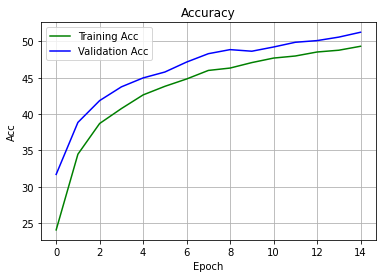

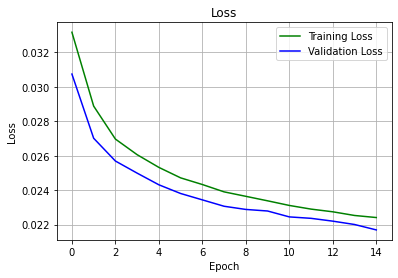

Test Accuracy: 51.64 %		Test Loss: 0.021748


In [39]:
plot_metrics(train_acc, train_loss, val_acc, val_loss)

acc_test, loss_test = evaluate(dense, testloader, criterion)
print('Test Accuracy: %2.2f %%' % acc_test,
        'Test Loss: %2.6f' % loss_test,
        sep='\t\t')

## **Question 3:** Convolutional  Neural Networks (40 pts)



We have provided you with a simple CNN. Your task is to improve the model and training method to achieve higher test accuracies.

**Notes and requirements:** 
- The minimum acceptable test accuracy is 75%
- The training time must be reasonable on Colab
- It is very likely to get different accuracies with each run due to the random initializations. However, we may deduct points if we cannot reproduce results that are reasonably close to your submitted results.
- You are welcome to experiment with the CNN architecture and anything else you want. You are required to experiment with different values for `learning_rate` and other parameters in your optimizer to improve your performance.
- **Write about your experimentations, how certain changes impacted performance and your understanding as to why.**

In [40]:
#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, ...)
#torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, ...)
#torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, ...)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32, 4)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linSize = 32*6*6
        self.fc1 = nn.Linear(self.linSize, 10)

    def forward(self, x):
        x = F.elu(self.pool(self.conv1(x)), inplace=True)
        x = self.bn1(x)
        
        x = F.elu(self.pool(self.conv2(x)), inplace=True)
        x = self.bn2(x)
        
        x = x.flatten(1, -1)
        x = self.fc1(x)
        return x

cnn = CNN().to(device)

print("Model Architecture")
print(cnn)
print("Number of parameters:", count_parameters(cnn))

Model Architecture
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=10, bias=True)
)
Number of parameters: 10


In [42]:
lr = 0.001
optimizer = torch.optim.Adam(cnn.parameters(),lr)
criterion = nn.CrossEntropyLoss()

train_acc, train_loss = [], []
val_acc, val_loss = [], []

print("Training on", device)
for epoch in range(15):
    
    acc_tr, loss_tr = train(cnn, trainloader, criterion, optimizer)
    train_loss.append(loss_tr)
    train_acc.append(acc_tr)

    acc_v, loss_v = evaluate(cnn, valloader, criterion)
    val_loss.append(loss_v)
    val_acc.append(acc_v)

    print('Epoch %2d' % (epoch + 1),
            'Train Accuracy: %2.2f' % acc_tr,
            'Val Accuracy: %2.2f' % acc_v,
            'Val Loss: %1.6f' % loss_v,
            sep='\t')
    

train_acc = torch.tensor(train_acc, device = 'cpu')
val_acc = torch.tensor(val_acc, device = 'cpu')

Training on cuda:0
Epoch  1	Train Accuracy: 50.50	Val Accuracy: 58.87	Val Loss: 0.018284
Epoch  2	Train Accuracy: 59.88	Val Accuracy: 63.84	Val Loss: 0.016535
Epoch  3	Train Accuracy: 63.07	Val Accuracy: 66.41	Val Loss: 0.015163
Epoch  4	Train Accuracy: 65.04	Val Accuracy: 67.93	Val Loss: 0.014824
Epoch  5	Train Accuracy: 66.24	Val Accuracy: 68.79	Val Loss: 0.014352
Epoch  6	Train Accuracy: 67.46	Val Accuracy: 68.65	Val Loss: 0.014155
Epoch  7	Train Accuracy: 68.30	Val Accuracy: 69.63	Val Loss: 0.013744
Epoch  8	Train Accuracy: 68.86	Val Accuracy: 70.46	Val Loss: 0.013418
Epoch  9	Train Accuracy: 69.28	Val Accuracy: 71.48	Val Loss: 0.012982
Epoch 10	Train Accuracy: 69.70	Val Accuracy: 71.89	Val Loss: 0.012822
Epoch 11	Train Accuracy: 70.25	Val Accuracy: 71.36	Val Loss: 0.013046
Epoch 12	Train Accuracy: 70.38	Val Accuracy: 71.16	Val Loss: 0.013016
Epoch 13	Train Accuracy: 70.92	Val Accuracy: 72.56	Val Loss: 0.012559
Epoch 14	Train Accuracy: 71.17	Val Accuracy: 71.89	Val Loss: 0.012809
E

Plot your peroformance using `plot_metrics` then evaluate your performance on the testloader / testset

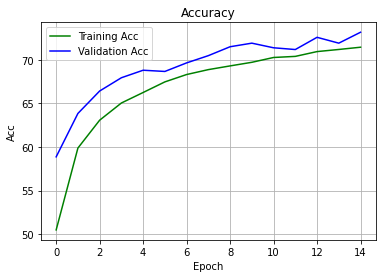

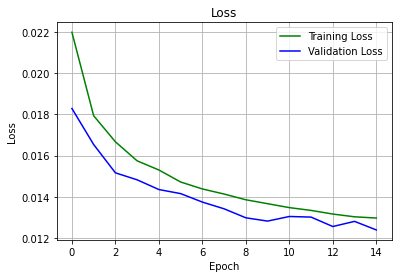


 Learning rate: 0.001000 		
 Test Accuracy: 72.81 %		Test Loss: 0.012406


In [43]:
plot_metrics(train_acc, train_loss, val_acc, val_loss)

acc_test, loss_test = evaluate(cnn, testloader, criterion)
print('\n Learning rate: %f ' % lr,
      '\n Test Accuracy: %2.2f %%' % acc_test,
        'Test Loss: %2.6f' % loss_test,
        sep='\t\t')

The test accuracy is shown below for a number of learning rates. Of those tested, the optimal learing rate was 0.001, the default for the Adam optimizer. 

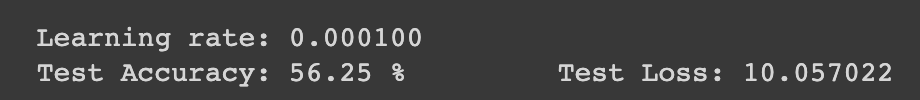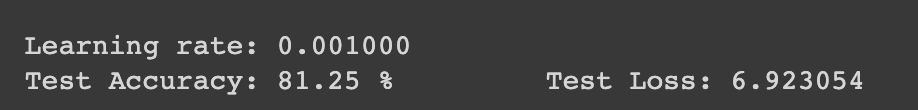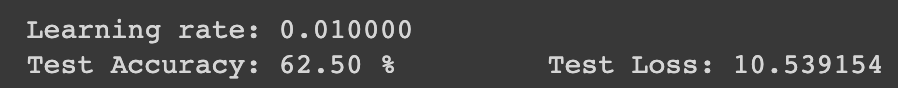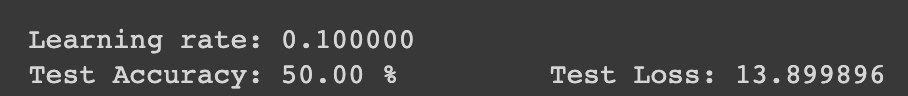

## Question 4 LSTM (10 points) 
For this question, please read the code to understand its setup. Add a line of code to preprocess the joke dataset by removing non-letter characters. Add several lines of code to train the dataset and predict. Code and dataset are adapted from https://www.kdnuggets.com/2020/07/pytorch-lstm-text-generation-tutorial.html

In [44]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset

### Create a folder and download the dataset

In [45]:
%pwd
%mkdir text-generation
!wget https://raw.githubusercontent.com/amoudgl/short-jokes-dataset/master/data/reddit-cleanjokes.csv -P /content/text-generation/

--2022-12-13 01:37:24--  https://raw.githubusercontent.com/amoudgl/short-jokes-dataset/master/data/reddit-cleanjokes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141847 (139K) [text/plain]
Saving to: ‘/content/text-generation/reddit-cleanjokes.csv’

reddit-cleanjokes.c 100%[===================>] 138.52K  --.-KB/s    in 0.007s  

2022-12-13 01:37:24 (18.1 MB/s) - ‘/content/text-generation/reddit-cleanjokes.csv’ saved [141847/141847]



# Initialize LSTM model 


In [46]:
class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

### Load the dataset 
Add a line of code to remove non-letter characters

In [47]:
from collections import Counter
import re

class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        sequence_length 
    ):
        self.sequence_length = sequence_length
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self):
        train_df = pd.read_csv('text-generation/reddit-cleanjokes.csv')
        train_df.Joke.str.replace('[^a-zA-Z0-9]','',regex=True)
        print(train_df)
        text = train_df.Joke
        text = text.str.cat(sep=' ')
        print(text)
        return text.split(' ')

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.sequence_length]),
            torch.tensor(self.words_indexes[index+1:index+self.sequence_length+1]),
        )

## Training 


In [48]:
from torch.utils.data import DataLoader

def train(dataset, model,sequence_length):
    model.train()

    dataloader = DataLoader(dataset, batch_size=256) # batch-size set to 256
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(3): #maximum epoch set to 3
        state_h, state_c = model.init_state(sequence_length)  

        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()
            optimizer.step()

            print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })

## Predict 

In [49]:
# The model predict next 10 words after the input text (You can customize it)
def predict(dataset, model, text, next_words=10):
    model.eval()

    words = text.split(' ')
    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])

    return words

## Train the dataset and execute the prediction 

In [50]:
# Write code to train the dataset and predict the result. Include your own input text and sequence_length
sequence_length = 4

dataset = Dataset(sequence_length)
model = Model(dataset)
train(dataset,model,sequence_length)
print(predict(dataset,model,text='Knock knock'))

        ID                                               Joke
0        1  What did the bartender say to the jumper cable...
1        2  Don't you hate jokes about German sausage? The...
2        3  Two artists had an art contest... It ended in ...
3        4  Why did the chicken cross the playground? To g...
4        5   What gun do you use to hunt a moose? A moosecut!
...    ...                                                ...
1617  1618  What do you call a camel with 3 humps? Humphre...
1618  1619  Two fish in a tank. [x-post from r/Jokes] One ...
1619  1620          "Stay strong!" I said to my wi-fi signal.
1620  1621  Why was the tomato blushing? Because it saw th...
1621  1622    What is heavy forward but not backward? **ton**

[1622 rows x 2 columns]
What did the bartender say to the jumper cables? You better not try to start anything. Don't you hate jokes about German sausage? They're the wurst! Two artists had an art contest... It ended in a draw Why did the chicken cross the